# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install fast_ml;  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 2.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from fast_ml.model_development import train_valid_test_split  # для разбиения на 3 выборки

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict


In [4]:
RANDOM_STATE = 12345

### Загрузка данных и ознакомление с ними

In [5]:
from google.colab import drive   # подключение гугл-диска
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df_text = pd.read_csv('/content/drive/MyDrive/_PYTHON/YandexPracticum/Comment_classification/toxic_comments.csv') # загрузка данных

In [7]:
df_text.shape # почти 160 тысяч комментариев

(159292, 3)

In [8]:
df_text.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Комментарии необходимо лемматизировать и токенизировать перед тем, как строить модели

In [9]:
df_text.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


`Unnamed: 0	` бесполезный столбец, удалю его

In [10]:
df_text = df_text.drop(columns='Unnamed: 0')

In [11]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [12]:
df_text.toxic.unique() # всё верно, всего два значения 1 - токсичный, 0 - нормальный

array([0, 1])

In [13]:
def balance(data):
    data.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', labels=['Токсичный','Не токсичный'])
    plt.title('Баланс распределения классов в данных')
    plt.ylabel('')
    plt.show()    

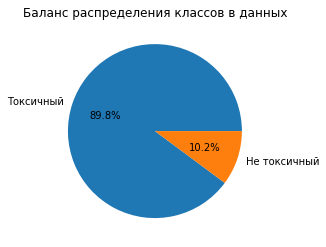

In [14]:
data = df_text.iloc[:,1]
balance(data)

Видим дисбаланс классов 9 к 1, что плохо повлияет на обучение моделей. Необходимо сбалансировать классы

### Лемматизация

In [15]:
corpus = list(df_text['text'])  # корпус слов

In [16]:
nltk.download('wordnet') # загрузка библиотеки для обработки слов

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
nltk.download('averaged_perceptron_tagger') # загрузка разметчика частей речи

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [23]:
nltk.download('punkt') # загрузка модели, которая будет делить на предложения

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
lemmatizer = WordNetLemmatizer() # создаем объект лемматайзер

In [19]:
def clear_text(text):            # функция по очистке текста от всего кроме букв и пробелов
    y=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k=" ".join(y.split())
    return k

In [20]:
def get_wordnet_pos(word):       # функция определения тегов для слова
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [25]:
test = "The striped bats are hanging on their feet for best"  # проверка
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(test)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [26]:
def lemma_func(text1):       # функция лемматизации
    k=[]
    for i in nltk.word_tokenize(text1):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 

In [27]:
def lemma_text(corpus):          # функция лемматизации и отчистки текста
    lemma=[]
    for i in tqdm(range(len(corpus))):
        lemma.append(lemma_func(clear_text(corpus[i])))
    return pd.Series(lemma, index=df_text.index)

In [29]:
%%time
df_text['lemma_text'] = lemma_text(corpus)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 24min 56s, sys: 1min 35s, total: 26min 31s
Wall time: 28min 3s


In [40]:
df_text.head() # посмотрим, как отработала функция лемматизации

,text,toxic,lemma_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D'aww He match this background colour I 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I 'm really not try to edit war It 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


### Разделение на выборки

In [41]:
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(
    df_text, target = 'toxic', train_size=0.8, valid_size=0.1, test_size=0.1, random_state=RANDOM_STATE) # на три выборки

In [42]:
print('Размер тренировочной выборки- {:.0%}'.format(features_train.shape[0]/df_text.shape[0]))
print('Размер валидационной выборки - {:.0%}'.format(features_valid.shape[0]/df_text.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(features_test.shape[0]/df_text.shape[0]))

Размер тренировочной выборки- 80%
Размер валидационной выборки - 10%
Размер тестовой выборки - 10%


In [43]:
nltk.download('stopwords') # библиотека и стоп-слова из английского языка
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
corpus_lemm_train = features_train['lemma_text'].values # корпус лемматизированных и очищенных слов
corpus_lemm_train.shape

(127433,)

In [49]:
features_train

,text,lemma_text
97400,Bushranger you're a GRASS with no sense of hum...,Bushranger you 're a GRASS with no sense of hu...
4383,"""\n\n Need administrative help \n\nI have been...",Need administrative help I have be block iniqu...
103680,I'd also like to point out that he has used a ...,I 'd also like to point out that he have use a...
38573,You cant block me you fucking retard. BRB nigger,You cant block me you fuck retard BRB nigger
128311,I believe that the frequency of the wave needs...,I believe that the frequency of the wave need ...
...,...,...
109993,Hahaha. ) I dont live in a lie like you and do...,Hahaha I dont live in a lie like you and dont ...
85412,March 2006 – March 2006]]\n \n\n|},March March
133249,"""\n\nAgreed. We really should try to stick to...",Agreed We really should try to stick to the su...
130333,"""\n\n Umm killer \n\nDo you not like that he c...",Umm killer Do you not like that he copy your w...


In [57]:
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words), analyzer='word') # Применим модель TfidfVectorizer

In [58]:
tf_train = count_tf_idf.fit_transform(corpus_lemm_train)                # обучим её на тренировочных данных

In [59]:
tf_train.shape

(127433, 139501)

In [60]:
corpus_lemm_test = features_test['lemma_text'].values     # то же самое для тестовых данных

In [61]:
tf_test = count_tf_idf.transform(corpus_lemm_test)          # трансформирование тестовой выборки
tf_test.shape

(15930, 139501)

In [62]:
corpus_lemm_valid = features_valid['lemma_text'].values    # то же самое для валидационных данных

In [63]:
tf_valid = count_tf_idf.transform(corpus_lemm_valid)          # трансформирование тестовой выборки
tf_valid.shape

(15929, 139501)

Выборки:
* features_train ->  tf_train
* features_valid -> tf_valid
* features_test -> tf_test

## Обучение

### DecisionTreeClassifier

In [64]:
%%time

best_model_dt = None
best_result_dt = 0
best_depth_dt=0

for depth in tqdm(range(1, 25, 3)):      
    model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, class_weight='balanced') 
    model_dt.fit(tf_train, target_train) 
    predict_dt = model_dt.predict(tf_valid)        # заменил tf_test на tf_valid
    result_dt = f1_score(target_valid, predict_dt)  # заменил target_test на target_valid
    
    if result_dt > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result_dt          
        best_depth_dt = depth
        
print("F1 наилучшей модели равно:", best_result_dt.round(2), end='')
print(' C глубиной:', best_depth_dt)

  0%|          | 0/8 [00:00<?, ?it/s]

F1 наилучшей модели равно: 0.6 C глубиной: 22
CPU times: user 1min 25s, sys: 201 ms, total: 1min 25s
Wall time: 1min 26s


In [65]:
target_names=['Отзыв токсичный','Отзыв не токсичный']

In [66]:
model_dt= DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=best_depth_dt)
model_dt.fit(tf_train, target_train)
predicted_dt=model_dt.predict(tf_valid)  # заменил tf_test на tf_valid

f1_forest_1 = f1_score(target_valid, predicted_dt)  # заменил target_test на target_valid
print(classification_report(target_valid, predicted_dt, target_names=target_names))
print('Метрика F1 качества предсказания модели "DecisionTreeClassifier" на валидационных данных равна :',f1_forest_1.round(2))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.95      0.99      0.97     14322
Отзыв не токсичный       0.87      0.55      0.67      1607

          accuracy                           0.95     15929
         macro avg       0.91      0.77      0.82     15929
      weighted avg       0.94      0.95      0.94     15929

Метрика F1 качества предсказания модели "DecisionTreeClassifier" на валидационных данных равна : 0.67


In [67]:
y_pred = cross_val_predict(model_dt, tf_train, target_train, cv=5)
conf_matrix = confusion_matrix(target_train, y_pred)
conf_matrix #  матрица ошибок на выборке train

array([[113516,    961],
       [  6161,   6795]])

### LogisticRegression

In [68]:
%%time

clf_lr = LogisticRegression(random_state=RANDOM_STATE, solver='sag', class_weight='balanced') # liblinear sag
parametrs_lr = {'C': range (1, 10), 'max_iter': range (10,30,2) }   # увеличим кол-во иттераций с 15 до 22

grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(tf_train, target_train)
grid_lr.best_params_

CPU times: user 7min 10s, sys: 382 ms, total: 7min 11s
Wall time: 7min 22s


{'C': 4, 'max_iter': 24}

In [69]:
grid_lr.best_score_ # лучший результат на кросс-валидации

0.7554266801345393

In [70]:
predicted_lr= grid_lr.predict(tf_valid)                      # заменил tf_test на tf_valid

f1_log_r_1 = f1_score(target_valid, predicted_lr).round(3)                          # заменил target_test на target_valid
print(classification_report(target_valid, predicted_lr, target_names=target_names))
print('Метрика F1 качества предсказания модели "LogisticRegression" на валидационных данных равна :',f1_log_r_1)

                    precision    recall  f1-score   support

   Отзыв токсичный       0.98      0.95      0.97     14322
Отзыв не токсичный       0.67      0.85      0.75      1607

          accuracy                           0.94     15929
         macro avg       0.83      0.90      0.86     15929
      weighted avg       0.95      0.94      0.95     15929

Метрика F1 качества предсказания модели "LogisticRegression" на валидационных данных равна : 0.751


### RandomForestClassifier

In [71]:
%%time

best_model_rf = None
best_result_rf = 0
best_depth_rf=0

for est in tqdm(range(1, 12, 4)):      
    model_rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, class_weight='balanced_subsample') 
    model_rf.fit(tf_train, target_train) 
    predict_rf=model_rf.predict(tf_valid)             # заменил tf_test на tf_valid
    result_rf = f1_score(target_valid, predict_rf)     # заменил target_test на target_valid
    
    if result_rf > best_result_rf:
        best_model_rf = model_rf
        best_result_rf = result_rf          
        best_depth_rf = est
        
print("F1 наилучшей модели равно:", best_result_rf.round(2), end='')
print(' C глубиной:', best_depth_rf)

  0%|          | 0/3 [00:00<?, ?it/s]

F1 наилучшей модели равно: 0.6 C глубиной: 9
CPU times: user 2min 15s, sys: 156 ms, total: 2min 15s
Wall time: 2min 25s


In [72]:
predict_rfc = model_rf.predict(tf_valid)               # заменил tf_test на tf_valid
f1_random_forest = f1_score(target_valid, predict_rfc)  # заменил target_test на target_valid
print(classification_report(target_valid, predict_rfc, target_names=target_names))
print('Метрика F1 качества предсказания модели "RandomForestClassifier" на валидационных данных равна :',f1_random_forest.round(2))

                    precision    recall  f1-score   support

   Отзыв токсичный       0.94      0.99      0.97     14322
Отзыв не токсичный       0.83      0.47      0.60      1607

          accuracy                           0.94     15929
         macro avg       0.89      0.73      0.78     15929
      weighted avg       0.93      0.94      0.93     15929

Метрика F1 качества предсказания модели "RandomForestClassifier" на валидационных данных равна : 0.6


In [ ]:
grid_lr.best_params_

{'C': 4, 'max_iter': 24}

In [74]:
best_model = LogisticRegression(random_state=RANDOM_STATE, **grid_lr.best_params_, solver='sag', class_weight='balanced')
best_model.fit(tf_train, target_train)
predicted_lr = best_model.predict(tf_test)

In [75]:
f1_log_r_1 = f1_score(target_test, predicted_lr).round(3)                         
print('Метрика F1 качества предсказания модели "LogisticRegression" на тестовых данных равна :',f1_log_r_1)

Метрика F1 качества предсказания модели "LogisticRegression" на тестовых данных равна : 0.754


## Выводы

Цель проекта — найти и обучить модель для магазина "ВИКИШОП", которая способна классифицировать комментарии на позитивные и токсичные, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. Результата предсказания наилучшей модели по мере F1 должен быть не меньше 0.75

Был дан датасет с данными с разметкой токсичности комментариев. Перед обучением моделей, данные были отчищены от лишних символов. Проведена балансировка классов в выборке.

Проверены три модели предсказательных алгоритмов: DecisionTreeClassifier, LogisticRegression и RandomForestClassifier. 

* DecisionTreeClassifier — самая быстрая модель — обучение и предсказание около минуты, но метрика F1: 0.67
* LogisticRegression — самая медленная около семи минут, метрика F1: 0.751
* RandomForestClassifier — 1 минута 40 секунд, метрика F1: 0.68

Так как, для заказчика самый важный параметр - точность по метрике F1, то победила модель LogisticRegression, на тестовых данных метрика F1: 0.755

Её можно рекомендовать в работе для магазина "ВИКИШОП".